###Problem Statement <br>
Curious about the food Americans eat? Look no further.

**Instacart**, an American company that operates a grocery delivery and pick-up service in the United States and Canada, has publicly provided an open-source anonymized dataset containing over *3 million grocery orders* from more than *200,000 Instacart users*. 


The Instacart Online Grocery Shopping Dataset 2017" </a> the data set describes customers' orders over time. <br>
Following tasks needs to be done:
1. Create clusters for the different types of products that the customers buy 
2. Infer patterns based on clusters formed to draw business insights
<br>
 

Overview of the broad steps involved:
 1. Loading the data set and the required libraries
 2. Preparing data for model building
  *  Removing Null values from the data
  *  Applying standardization to the dataset
 4. Feature selection for product clustering
 5. Building clustering models
 6. Calculating reorder rates for clusters based on different parameters
 7. Comparison analysis and summarization
 

### 1. Loading data set and the required libraries


In [2]:
### 1. Loading the libraries and required libraries 
import os
import zipfile
import glob
import seaborn as sns
import datetime
import random

# Importing ML libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
sns.set()

In [4]:
data_directory_path = '/kaggle/working/dataset/'

# Converting the days and hours from numbers to their interpretable form
days_of_week = {0: 'Saturday', 
                1: 'Sunday', 
                2: 'Monday',
                3: 'Tuesday',
                4: 'Wednesday',
                5: 'Thursday',
                6: 'Friday'}
hour_nums = list(range(24))
hours_of_day = {hour_num:datetime.time(hour_num).strftime("%I:00 %p") for hour_num in hour_nums}

In [5]:
# Unziping all dataset tables. Placing unzipped files in /kaggle/working/dataset directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        with zipfile.ZipFile(os.path.join(dirname, filename), 'r') as zip_ref:
            zip_ref.extractall(data_directory_path)

In [6]:
''' 
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
'''
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object, 'category']:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data


In [7]:
# Reading the csv files into corresponding dataframes
# Then reduce their size to consume less memory
aisles = pd.read_csv(data_directory_path + 'aisles.csv')
aisles = reduce_mem_usage(aisles)

departments = pd.read_csv(data_directory_path + 'departments.csv')
departments = reduce_mem_usage(departments)

order_products_prior = pd.read_csv(data_directory_path + 'order_products__prior.csv')
order_products_prior = reduce_mem_usage(order_products_prior)

order_products_train = pd.read_csv(data_directory_path + 'order_products__train.csv')
order_products_train = reduce_mem_usage(order_products_train)

orders = pd.read_csv(data_directory_path + 'orders.csv')
# Replacing numbers with their corresponding hour representation
orders['order_hour_of_day'] = orders['order_hour_of_day'].replace(to_replace=hours_of_day, value=None)
orders['order_hour_of_day'] = pd.Categorical(orders['order_hour_of_day'], 
                                             ordered=True, 
                                             categories=list(hours_of_day.values()))
# Replacing numbers with their corresponding day of week
# Define the categories of days of week sorted normally from Saturday to Friday
orders['order_dow'] = orders['order_dow'].replace(to_replace=days_of_week, value=None)
orders['order_dow'] = pd.Categorical(orders['order_dow'], 
                                     ordered=True, 
                                     categories=list(days_of_week.values()))
orders = reduce_mem_usage(orders)

products = pd.read_csv(data_directory_path + 'products.csv')
products = reduce_mem_usage(products)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.01 MB
Decreased by -159.9%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -92.7%
Memory usage of dataframe is 989.82 MB
Memory usage after optimization is: 340.25 MB
Decreased by 65.6%
Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 13.20 MB
Decreased by 68.7%
Memory usage of dataframe is 137.03 MB
Memory usage after optimization is: 45.68 MB
Decreased by 66.7%
Memory usage of dataframe is 1.52 MB
Memory usage after optimization is: 1.91 MB
Decreased by -25.8%


In [8]:
# Merging the Prior and train order_products
order_products = pd.concat([order_products_train, order_products_prior])
instacart_df = order_products.merge(products, on='product_id', how='left').merge(orders, on='order_id', how='left').merge(departments, on='department_id').merge(aisles, on='aisle_id')

In [9]:
instacart_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   product_id              int32   
 2   add_to_cart_order       int16   
 3   reordered               int8    
 4   product_name            category
 5   aisle_id                int16   
 6   department_id           int8    
 7   user_id                 int32   
 8   eval_set                category
 9   order_number            int8    
 10  order_dow               category
 11  order_hour_of_day       category
 12  days_since_prior_order  float16 
 13  department              category
 14  aisle                   category
dtypes: category(6), float16(1), int16(2), int32(3), int8(3)
memory usage: 1.2 GB


In [10]:
#Checking for null values
instacart_df.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
department                      0
aisle                           0
dtype: int64

In [12]:
# Aisle and department are categorical variables. Let us check the numbers of categories they have
instacart_df['aisle_id'].nunique(), instacart_df['department_id'].nunique()

(134, 21)

aisle_id column has 134 categories, and the department_id column has 21. When forming clusters, categorical variables with a low number of values could help the algorithm deliver better results by adding another dimension. But since, in this case, the number of categories is high, it won't add value to the clustering quality by the algorithm.

Let's see how the Python sees these data points:

In [ ]:
#Using the describe function to check data distribution of the dataset
instacart_df.describe()

,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders
count,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000
mean,70.670255,11.396651,96.935113,59.192794,0.514981,9.283605,2.762032,13.604961,17.284002
std,38.380694,6.267054,372.921094,290.603486,0.175569,2.232181,0.444832,0.865993,2.429650
min,1.000000,1.000000,11.000000,0.000000,0.000000,2.125000,0.636364,8.714286,6.363000
25%,37.000000,6.000000,17.000000,8.000000,0.400000,7.900000,2.500000,13.125000,15.810000
50%,77.000000,13.000000,31.000000,15.000000,0.533333,9.327868,2.745763,13.591837,17.219999
75%,106.000000,16.000000,72.000000,39.000000,0.642857,10.646153,3.000000,14.086957,18.750000
max,134.000000,21.000000,18726.000000,16557.000000,1.000000,19.590910,5.000000,17.562500,29.230000


Some of the interesting insights from the data distribution pattern are as follows: 

*   order_mean_dow indicates that the initial days of the week have low traction.
*   order_mean_hour_of_day shows that the majority of orders start coming in post noon.




### 2. Preparing the data for Clustering

1.  Dropping irrelevant columns

In [ ]:
#Let us first drop unnecessary columns for our use case.
temp = instacart_df[instacart_df.columns.difference(['product_name', 'department_id', 'aisle_id'])]
#These columns are dropped as these features are irrelevant to our use case.

In [ ]:
#Let us now look at the updated dataset.
temp.head()

,add_to_cart_mean,mean_day_gap_in_orders,num_orders,num_reordered,order_mean_dow,order_mean_hour_of_day,reorder_rate
0,6.921052,17.120001,76,49,3.026316,12.960526,0.644737
1,8.954545,17.270000,22,14,2.727273,15.272727,0.636364
2,9.846154,15.080000,13,7,4.538462,13.461538,0.538462
3,8.285714,16.059999,119,70,2.865546,14.218488,0.588235
4,10.615385,13.540000,13,6,3.538461,14.692307,0.461538


2.  ####   Scaling with StandardScaler 

As we learned before, scaling is essential for clustering algorithms. We'll be using *standardization* as the scaling method in this demo.

In [ ]:
#Scaling the values using the sklearn standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()         
temp_scaled = scaler.fit_transform(temp)


In [ ]:
#Let us now print the values after standardization.
temp_scaled[:5]

array([[-1.05845095, -0.06750906, -0.05614028, -0.03507589,  0.59414367,
        -0.74422618,  0.73908156],
       [-0.14742791, -0.0057699 , -0.20094844, -0.15551941, -0.0781442 ,
         1.92587649,  0.69138824],
       [ 0.25202106, -0.90716411, -0.22508314, -0.17960812,  3.99364684,
        -0.16566344,  0.13374316],
       [-0.44707019, -0.50380078,  0.05916992,  0.03719023,  0.23271277,
         0.70845307,  0.41725189],
       [ 0.59664343, -1.54102106, -0.22508314, -0.18304936,  1.74551472,
         1.25561466, -0.30440686]])

### 3. Building Clustering Models - Part I

####1.   K-Means Clustering:

  * Step 1: Find the optimal number of clusters

---





*   Finding the Optimal Number of Clusters
  1.   WCSS Method -  in this method, we identify an elbow by plotting the sum of squared distances from each point to its cluster center (centroid).



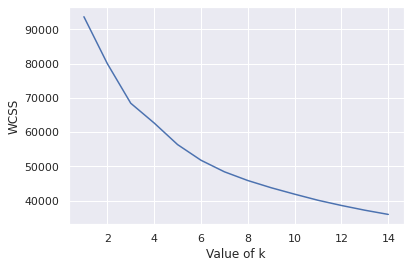

In [ ]:
# elbow-curve/WCSS
ssd = []
range_n_clusters = range(1, 15)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state=0)
    kmeans.fit(temp_scaled)
    
    ssd.append(kmeans.inertia_)
    
# Plot the SSDs for each n_clusters
plt.plot(range_n_clusters, ssd)
plt.xlabel("Value of k")
plt.ylabel("WCSS")
plt.show()

Considering the plot above for WCSS vs. K values, determining the elbow point is not easy or obvious.

Let's now try the Silhouette Analysis method to find the optimal value of K.

*   Finding the Optimal Number of Clusters
  2.   Silhouette Analysis Method

The Silhouette coefficient score for a data point is computed using the below formula:
$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the data point's cluster points.

* The value of the Silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in its cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [ ]:
# Silhouette score analysis
temp1 = []
range_n_clusters = range(2, 15)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=0)
    kmeans.fit(temp_scaled)
   
    temp1.append(silhouette_score(temp_scaled, kmeans.labels_))
print(temp1)


[0.8057103833679096, 0.1562771808987962, 0.13592384675085306, 0.13937343218969492, 0.13727966165369135, 0.1377586062522358, 0.13081776520646732, 0.1325742481471285, 0.12622218191100673, 0.12635588295064293, 0.1237393047795103, 0.12812518800640824, 0.12218092285186632]


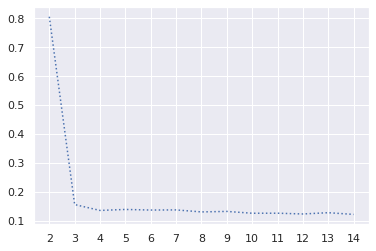

In [ ]:
#Visualizing variation in the Silhouette score
plt.plot(temp1, linestyle = 'dotted')
default_x_ticks = range(len(range_n_clusters))
plt.xticks(default_x_ticks, range_n_clusters)
plt.show()

Silhouette score quickly drops at K=3 and stabilizes around K = 5.

Let us visualize the Silhouette scores with SilhoetteVisualizer to better understand the distribution of Silhouette scores for different values of K in the neighborhood of the elbow point value of 3.

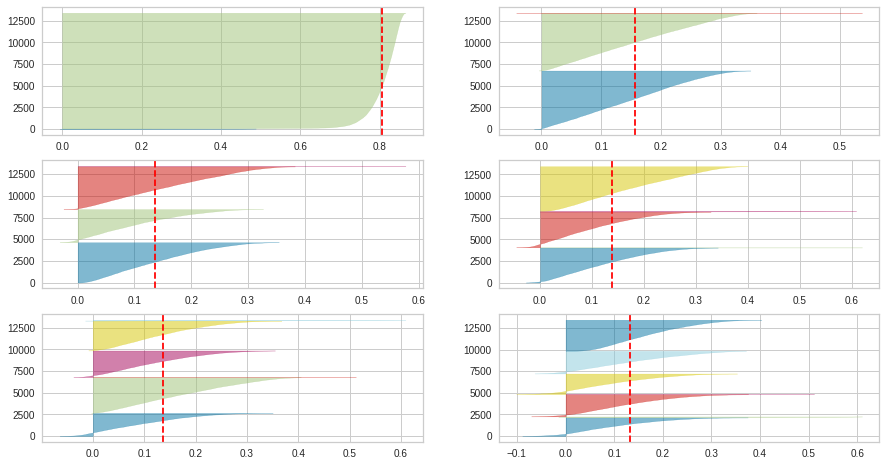

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
 
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5,6,7]:
    '''
    Create K-Means instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with K-Means instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(temp_scaled)
    #add title and legends

K = 5 gives us a nice uniform distribution with all clusters having above-average Silhouette scores, so let's proceed with that.

In [ ]:
# Final K-Means model with k=5
kmeans = KMeans(n_clusters=5, max_iter=50, random_state=0)
kmeans.fit(temp_scaled)

KMeans(max_iter=50, n_clusters=5, random_state=0)

In [ ]:
# Assigning the label to data points
instacart_df['cluster_id'] = kmeans.labels_
instacart_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders,cluster_id
0,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921052,3.026316,12.960526,17.120001,4
1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.270000,0
2,Cut Russet Potatoes Steam N' Mash,116,1,13,7,0.538462,9.846154,4.538462,13.461538,15.080000,2
3,Sparkling Orange Juice & Prickly Pear Beverage,115,7,119,70,0.588235,8.285714,2.865546,14.218488,16.059999,4
4,Chocolate Fudge Layer Cake,119,1,13,6,0.461538,10.615385,3.538461,14.692307,13.540000,2


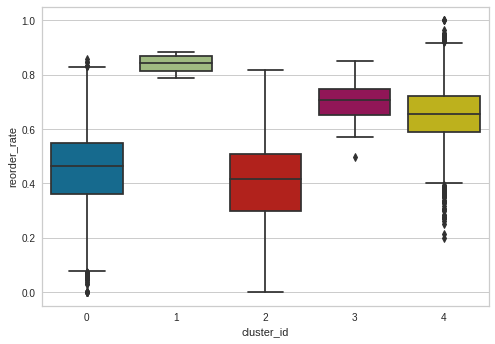

In [ ]:
# As the first step, let's plot the parameter of interest (reorder_rate) with different cluster ids and see if we can find a pattern.
sns.boxplot(x='cluster_id', y='reorder_rate', data=instacart_df)

#### Analyzing mean values for different columns to detect patterns based on cluster formation

In [ ]:
(instacart_df.groupby('cluster_id')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_num_reordered = ('num_reordered','mean'),
     mean_reorder_rate = ('reorder_rate','mean'),
     mean_add_to_cart_mean = ('add_to_cart_mean','mean'),
     mean_order_mean_dow = ('order_mean_dow','mean'),
     mean_order_mean_hour_of_day = ('order_mean_hour_of_day','mean'),
     mean_mean_day_gap_in_orders = ('mean_day_gap_in_orders','mean')
     ))

# [['num_orders','num_reordered','reorder_rate','add_to_cart_mean','order_mean_dow','order_mean_hour_of_day','mean_day_gap_in_orders']].mean().reset_index()
# .merge(instacart_df['cluster_id_random'].value_counts().reset_index().rename(columns = {'index':'cluster_id_random','cluster_id_random':'num_products_in_cluster'})))

,num_products_in_cluster,mean_num_orders,mean_num_reordered,mean_reorder_rate,mean_add_to_cart_mean,mean_order_mean_dow,mean_order_mean_hour_of_day,mean_mean_day_gap_in_orders
cluster_id,,,,,,,,
0,4034,51.615022,24.343580,0.449068,9.839949,2.554951,14.006989,19.214939
1,4,13721.000000,11644.250000,0.840083,6.306344,2.608582,13.561049,16.253750
2,4114,51.086048,21.907146,0.399724,10.673822,2.936973,13.355541,16.138771
3,79,2969.670886,2116.784810,0.705388,8.203812,2.614335,13.553150,16.691811
4,5146,114.424796,75.726972,0.655618,7.754991,2.786895,13.490129,16.695818


Some observable insights based on the clusterwise data distribution are:


* Cluster **1** has the highest number of orders, along with the highest reorder rate; this group also has a very small number of products
* Cluster **3** also has a relatively high number of orders and reorder rate, but it has a small portfolio of products
* Cluster **4** has a high product count with relatively low demand and reorder rate
* Clusters **0** and **2** have the least number of orders. This is coupled with a relatively low reorder rate, although the number of products is relatively high
* Apart from 'number of products', 'total number of orders placed', and 'the reorder rate', other variables do not show significant variation for the different clusters.

#### Experimenting with other modes of Centroid Initialization


In [ ]:
# By default, the K-means algorithm applies the K-means++ centroid initialization technique to the algorithm to get better initial cluster centers.
# Now, let us check what happens when we choose random cluster center initialization

kmeansrm = KMeans(n_clusters=5, max_iter=50, init='random', random_state=0)
kmeansrm.fit(temp_scaled)

KMeans(init='random', max_iter=50, n_clusters=5, random_state=0)

In [ ]:
#Taking the labels assigned after clustering for all the data points
ymeansrm = kmeansrm.labels_

In [ ]:
labelsrm, countsrm = np.unique(ymeansrm, return_counts=True)


In [ ]:
instacart_df['cluster_id_random'] = ymeansrm

In [ ]:
instacart_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders,cluster_id,cluster_id_random
0,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921052,3.026316,12.960526,17.120001,4,1
1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.270000,0,1
2,Cut Russet Potatoes Steam N' Mash,116,1,13,7,0.538462,9.846154,4.538462,13.461538,15.080000,2,4
3,Sparkling Orange Juice & Prickly Pear Beverage,115,7,119,70,0.588235,8.285714,2.865546,14.218488,16.059999,4,1
4,Chocolate Fudge Layer Cake,119,1,13,6,0.461538,10.615385,3.538461,14.692307,13.540000,2,4


In [ ]:
#Printing the mean value for all the variables with random centroid initialization
(instacart_df.groupby('cluster_id_random')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_num_reordered = ('num_reordered','mean'),
     mean_reorder_rate = ('reorder_rate','mean'),
     mean_add_to_cart_mean = ('add_to_cart_mean','mean'),
     mean_order_mean_dow = ('order_mean_dow','mean'),
     mean_order_mean_hour_of_day = ('order_mean_hour_of_day','mean'),
     mean_mean_day_gap_in_orders = ('mean_day_gap_in_orders','mean')
     ))

# [['num_orders','num_reordered','reorder_rate','add_to_cart_mean','order_mean_dow','order_mean_hour_of_day','mean_day_gap_in_orders']].mean().reset_index()
# .merge(instacart_df['cluster_id_random'].value_counts().reset_index().rename(columns = {'index':'cluster_id_random','cluster_id_random':'num_products_in_cluster'})))

,num_products_in_cluster,mean_num_orders,mean_num_reordered,mean_reorder_rate,mean_add_to_cart_mean,mean_order_mean_dow,mean_order_mean_hour_of_day,mean_mean_day_gap_in_orders
cluster_id_random,,,,,,,,
0,3396,69.904299,36.420200,0.502167,10.763557,2.592385,13.467814,15.322877
1,4070,156.199263,105.614005,0.673796,7.419403,2.744807,13.485688,17.116119
2,28,5954.357143,4586.785714,0.740680,7.948964,2.597192,13.562623,16.504679
3,3117,49.046840,20.910812,0.407068,10.140546,2.493257,13.822398,19.471455
4,2766,37.590022,16.153651,0.416349,9.257521,3.300217,13.704416,17.481770


####**Summary**
Via the random initialization method, we observe that clusters formed have similar mean values for the variables. 

*   Cluster 2 has a very small product portfolio but a much higher order and reorder counts.  
*   Clusters 0, 3, and 4 have comparable product counts, number of orders, and reorder rates.
*   Cluster 1 has the second-highest reorder rate with a slightly elevated number of orders and a large product count.

In conclusion, both K-Means++ and Random Initialization give us valuable insights. We can try different initialization methods and then use results from the one that makes the most sense for our business case. 

Also, we can enhance this analysis by including other factors such as acquisition cost, shipping cost, weight, supply chain factors, etc., to make richer observations and use them to inform our business decisions.

####**Evaluation**:
Analysis of results of both tables using K-Means++ and random initialization methods show that other than 2 attributes, namely num_orders and reorder_rate, other remaining attribute values do not change an appreciable amount.  This suggests that they do not contribute to cluster formation quality.

For much larger datasets, computational effort to determine clusters might be significant. We can address this issue by reducing the number of attributes which we employ for the clustering algorithm.

Accordingly, we can try a simpler model to see whether reducing complexity by using smaller number of attributes helps us achieve results comparable to those obtained using a larger number of attributes.

Let us now try a more focused approach by keeping only significant variables for the algorithm, namely 'num_orders' and 'reorder_rate'

In [ ]:
focussed_data = instacart_df[['num_orders', 'reorder_rate']].copy()
#Let's scale these values for our clustering algorithm, we'll call this data frame 'scaled_df1'.
scaled_df1 = scaler.fit_transform(focussed_data[['num_orders', 'reorder_rate']])

In [ ]:
#Printing values after scaling
scaled_df1[:5]

array([[-0.05614028,  0.73908156],
       [-0.20094844,  0.69138824],
       [-0.22508314,  0.13374316],
       [ 0.05916992,  0.41725189],
       [-0.22508314, -0.30440686]])

####Applying K-Means on the focused dataframe
For this, we'll reapply the steps of model building:

Step 1: Finding the Optimal Number of Clusters
  1.  WCSS Method




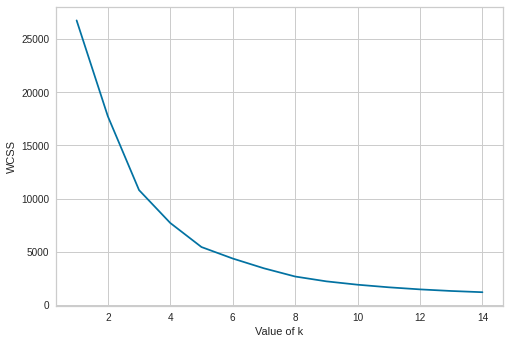

In [ ]:
# elbow-curve/WCSS
ssd = []
range_n_clusters = range(1, 15)
for num_clusters in range_n_clusters:
    kmeansv2 = KMeans(n_clusters=num_clusters, max_iter=50, init='k-means++', random_state=0)
    kmeansv2.fit(scaled_df1)
    
    ssd.append(kmeansv2.inertia_)
    
# Plot the SSDs for each n_clusters
# ssd
plt.plot(range_n_clusters, ssd)
plt.xlabel("Value of k")
plt.ylabel("WCSS")
plt.show()

2.   Silhouette Score analysis method:



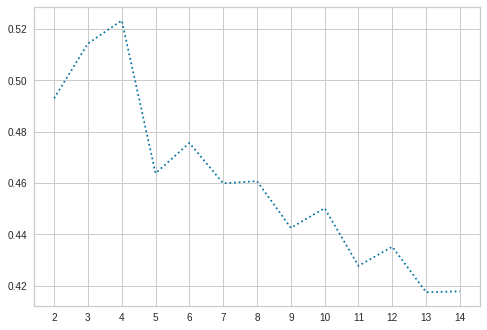

In [ ]:
# silhouette analysis
range_n_clusters = range(2,15)
temp2=[]

for num_clusters in range_n_clusters:
    
    # intialise K-Means
    kmeansv2 = KMeans(n_clusters=num_clusters, max_iter=50, init='k-means++', random_state=0)
    kmeansv2.fit(scaled_df1)
    
    cluster_labels_v2 = kmeansv2.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(scaled_df1, cluster_labels_v2)
    temp2.append(silhouette_score(scaled_df1, kmeansv2.labels_))

    #print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

#Visualizing variation in the Silhouette score:
    
plt.plot(temp2, linestyle = 'dotted')
default_x_ticks = range(len(range_n_clusters))
plt.xticks(default_x_ticks, range_n_clusters)
plt.show()

In [ ]:
# Final model with k=4
kmeansv2 = KMeans(n_clusters=4, max_iter=50, init='k-means++', random_state=0)
kmeansv2.fit(scaled_df1)

KMeans(max_iter=50, n_clusters=4, random_state=0)

In [ ]:
instacart_df['cluster_id_v2'] = kmeansv2.labels_
instacart_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders,cluster_id,cluster_id_random,cluster_id_v2
0,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921052,3.026316,12.960526,17.120001,4,1,2
1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.270000,0,1,2
2,Cut Russet Potatoes Steam N' Mash,116,1,13,7,0.538462,9.846154,4.538462,13.461538,15.080000,2,4,2
3,Sparkling Orange Juice & Prickly Pear Beverage,115,7,119,70,0.588235,8.285714,2.865546,14.218488,16.059999,4,1,2
4,Chocolate Fudge Layer Cake,119,1,13,6,0.461538,10.615385,3.538461,14.692307,13.540000,2,4,1


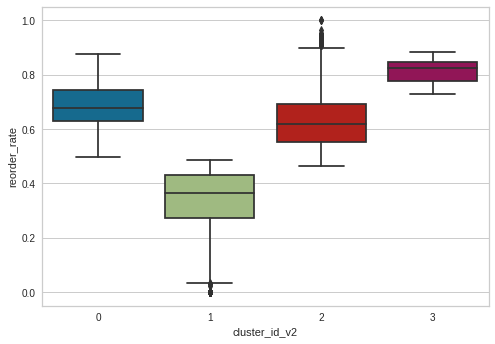

In [ ]:
# Plotting the boxplot for reorder_rate for the clusters formed
sns.boxplot(x='cluster_id_v2', y='reorder_rate', data=instacart_df)

#### Let us now check the mean value of different columns with the updated cluster labels.

In [ ]:
labels, counts = np.unique(kmeansv2.labels_, return_counts=True)


In [ ]:
(instacart_df.groupby('cluster_id_v2')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_num_reordered = ('num_reordered','mean'),
     mean_reorder_rate = ('reorder_rate','mean'),
     mean_add_to_cart_mean = ('add_to_cart_mean','mean'),
     mean_order_mean_dow = ('order_mean_dow','mean'),
     mean_order_mean_hour_of_day = ('order_mean_hour_of_day','mean'),
     mean_mean_day_gap_in_orders = ('mean_day_gap_in_orders','mean')
     ))


,num_products_in_cluster,mean_num_orders,mean_num_reordered,mean_reorder_rate,mean_add_to_cart_mean,mean_order_mean_dow,mean_order_mean_hour_of_day,mean_mean_day_gap_in_orders
cluster_id_v2,,,,,,,,
0,123,2176.512195,1510.186992,0.687332,8.298452,2.625500,13.556734,16.793440
1,5300,42.956226,15.559057,0.338975,9.948042,2.776305,13.625201,17.573551
2,7946,90.247546,57.142210,0.629411,8.858232,2.754795,13.592312,17.099264
3,8,10526.875000,8694.250000,0.811776,6.765075,2.593823,13.559857,16.517624


#### Let us now check how the clusters look like visually

In [ ]:
labels = np.unique(kmeansv2.labels_)
labels

array([0, 1, 2, 3], dtype=int32)

In [ ]:
y_kmeansv2 = kmeansv2.fit_predict(scaled_df1)

In [ ]:
y_kmeansv2[:5]

array([2, 2, 2, 2, 1], dtype=int32)

In [ ]:
X = pd.DataFrame(scaled_df1)


In [ ]:
kmeansv2.cluster_centers_

array([[ 5.57666180e+00,  9.81702700e-01],
       [-1.44751543e-01, -1.00252166e+00],
       [-1.79335968e-02,  6.51785953e-01],
       [ 2.79692673e+01,  1.69052605e+00]])

In [ ]:
# for i in labels:
#     plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
# plt.legend()
# plt.show()

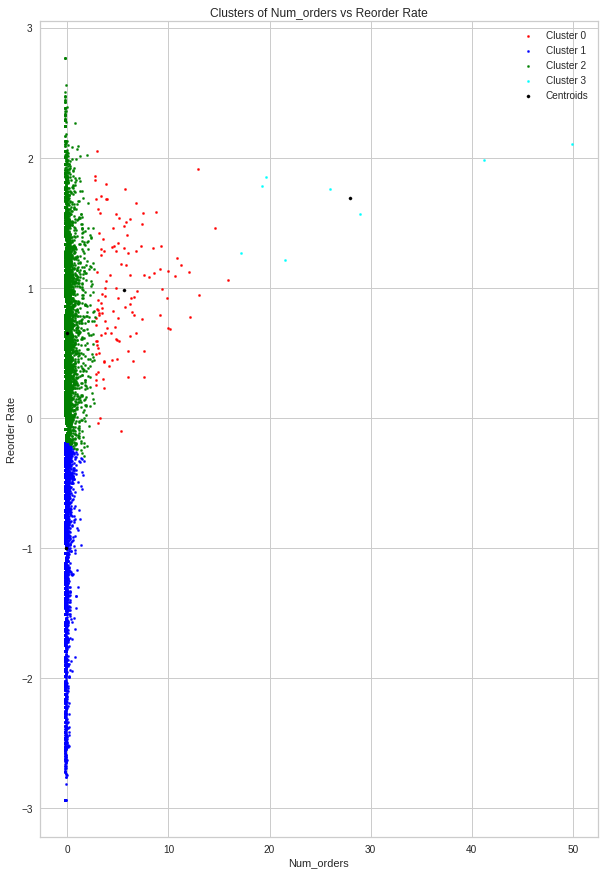

In [ ]:
plt.figure(figsize =(10, 15))

plt.scatter(X[kmeansv2.labels_== 0][0], X[kmeansv2.labels_== 0][1], s=5, c='red', label ='Cluster 0')
plt.scatter(X[kmeansv2.labels_== 1][0], X[kmeansv2.labels_== 1][1], s=5, c='blue', label ='Cluster 1')
plt.scatter(X[kmeansv2.labels_== 2][0], X[kmeansv2.labels_== 2][1], s=5, c='green', label ='Cluster 2')
plt.scatter(X[kmeansv2.labels_== 3][0], X[kmeansv2.labels_== 3][1], s=5, c='cyan', label ='Cluster 3')

plt.scatter(kmeansv2.cluster_centers_[:, 0], kmeansv2.cluster_centers_[:, 1], s=10, c='black', label = 'Centroids')
plt.title('Clusters of Num_orders vs Reorder Rate')
plt.xlabel('Num_orders')
plt.ylabel('Reorder Rate')
plt.legend()
plt.show()


Summarizing the results we got via the K-Means algorithm: 

In [ ]:
#Printed again for reference
(instacart_df.groupby('cluster_id_v2')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_num_reordered = ('num_reordered','mean'),
     mean_reorder_rate = ('reorder_rate','mean'),
     mean_add_to_cart_mean = ('add_to_cart_mean','mean'),
     mean_order_mean_dow = ('order_mean_dow','mean'),
     mean_order_mean_hour_of_day = ('order_mean_hour_of_day','mean'),
     mean_mean_day_gap_in_orders = ('mean_day_gap_in_orders','mean')
     ))


,num_products_in_cluster,mean_num_orders,mean_num_reordered,mean_reorder_rate,mean_add_to_cart_mean,mean_order_mean_dow,mean_order_mean_hour_of_day,mean_mean_day_gap_in_orders
cluster_id_v2,,,,,,,,
0,123,2176.512195,1510.186992,0.687332,8.298452,2.625500,13.556734,16.793440
1,5300,42.956226,15.559057,0.338975,9.948042,2.776305,13.625201,17.573551
2,7946,90.247546,57.142210,0.629411,8.858232,2.754795,13.592312,17.099264
3,8,10526.875000,8694.250000,0.811776,6.765075,2.593823,13.559857,16.517624


We have four different clusters in our simpler Kmeans clustering model, each with notably different reorder rates and the number of products with the cluster.
* There are 8 products within (***cluster 3***) that only get reordered 81% of the time.
*Another cluster (***cluster 0***) with 123 products getting a high reorder rate of 68%.
*Again, we have a midrange demand group (***cluster 2***) with 7946 products that get repeat orders 62% of the time 
*Finally a underperforming group ( ***cluster 1***) that gets only 33% reorders

Also, notice that even after reducing the model to just 2 clusters, we could still create meaningful clusters that give us useful insights into the data. Hence, this model gives us the insights needed with the advantage of significantly reduced model complexity.

This information might help Instacart formulate more useful product clusters for customer segmentation and market basket analysis.



---



### Building Clustering Models - Part II
#### **2. DBSCAN**

Now that we have analyzed the clustering outputs using the K-Means algorithm, let's give DBSCAN algorithm a try to see if it could perform better.

We will be using 2-dimensional data created earlier for this demo.

In [ ]:
#Scaling the variables and storing them in a new data frame to start afresh
temp2_scaled = scaler.fit_transform(focussed_data[['num_orders', 'reorder_rate']])

In [ ]:
temp2_scaled = pd.DataFrame(temp2_scaled)
temp2_scaled.columns = ['F1', 'F2']
temp2_scaled.head()

,F1,F2
0,-0.056140,0.739082
1,-0.200948,0.691388
2,-0.225083,0.133743
3,0.059170,0.417252
4,-0.225083,-0.304407


In [ ]:
from sklearn.cluster import DBSCAN


Recall that just as we find an optimal value for *K* for the Kmeans algorithm, we have *epsilon* and the minimum number of data points *MinPts* parameters to initialize for the DBSCAN algorithm.

Let's see how to find the optimal value for the eps(Epsilon) parameter for our use case:

Assume a value for MinPts, which is the same as k for k-nearest neighbors determination for a given point.
*   Step 1: Calculate the average of distances from a data point to its k nearest neighbors (kNN)
*   Step 2: Plot the average kNN distances for the data points in ascending order
* Step 3: Determine the focus point (elbow) with the highest curvature
* Step 4: (If required) Zoom into that range to find the optimal value for the Epsilon

Let's start with finding the optimal value for Epsilon first:



#####Finding Optimal value for Epsilon

We need to find a value of epsilon; let's plot distances against data points.

In [ ]:
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(temp2_scaled)
distances, indices = nbrs.kneighbors(temp2_scaled)
print(np.shape(distances))
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(temp2_scaled)
distances, indices = neighbors_fit.kneighbors(temp2_scaled)


(13377, 4)


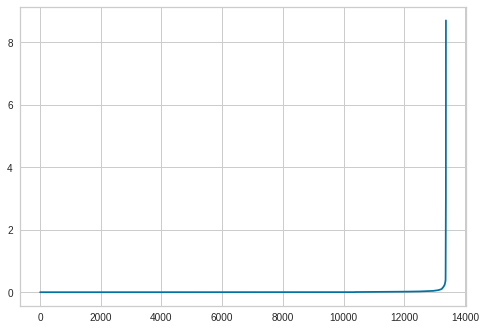

In [ ]:
# Step 3: Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
te1=pd.DataFrame(distances)
te1

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
13372,2.049149
13373,2.982752
13374,2.982752
13375,8.705401


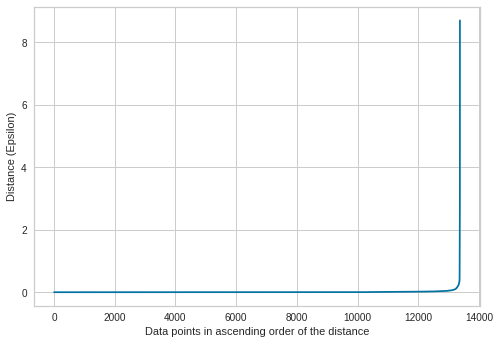

In [ ]:
distances = np.sort(distances, axis=0)
#distances = distances[:,1]
plt.plot(distances)
plt.ylabel("Distance (Epsilon)")
plt.xlabel("Data points in ascending order of the distance")
plt.show()


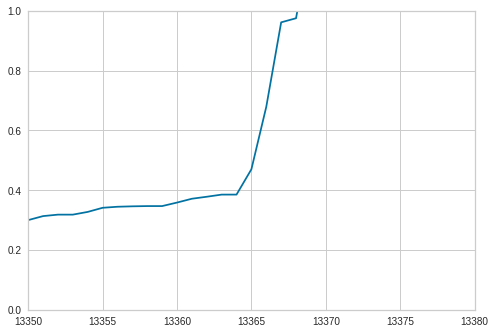

In [ ]:
#Zooming into the area of interest
plt.plot(distances)
plt.xlim([13350,13380])
#plt.xlim([13374,13380])
plt.ylim([0,1])
plt.show()


As the plot above shows, there is an elbow point at a distance value of around 0.5, so we can take eps=0.5.

##### Determining the MinPts value:
There is no plotting method or an automatic indicator to find a value for the MinPts parameter. 

A general rule of thumb based on the research done in this area entails the following:

*   Choose a large MinPts value if dataset has noise
*   For larger datasets choose MinPts = 2*(number of dimensions) (Sander et al., 1998)
* For 2D datasets, choose MinPts value = 4 (Ester et al., 1996)



In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=4).fit(temp2_scaled)
labels = db.labels_

instacart_df['cluster_label_dbscan'] = db.labels_

In [ ]:
# Please note that the label -1 is designated for outliers and the rest of the labels are used for the clusters formed
np.unique(labels, return_counts=True)

(array([-1,  0,  1]), array([   20, 13349,     8]))

In [ ]:
# Building the label to colour mapping
colours = {}
colours[0] = 'r'
colours[1] = 'g'
#colours[2] = 'b'
colours[-1] = 'k'
  
# Building the colour vector for each data point
cvec = [colours[label] for label in labels]

In [ ]:
r = plt.scatter(temp2_scaled['F1'], temp2_scaled['F2'], color ='r');
g = plt.scatter(temp2_scaled['F1'], temp2_scaled['F2'], color ='g');
#b = plt.scatter(temp2_scaled['F1'], temp2_scaled['F2'], color ='b');
k = plt.scatter(temp2_scaled['F1'], temp2_scaled['F2'], color ='k');
plt.clf()

<Figure size 576x396 with 0 Axes>

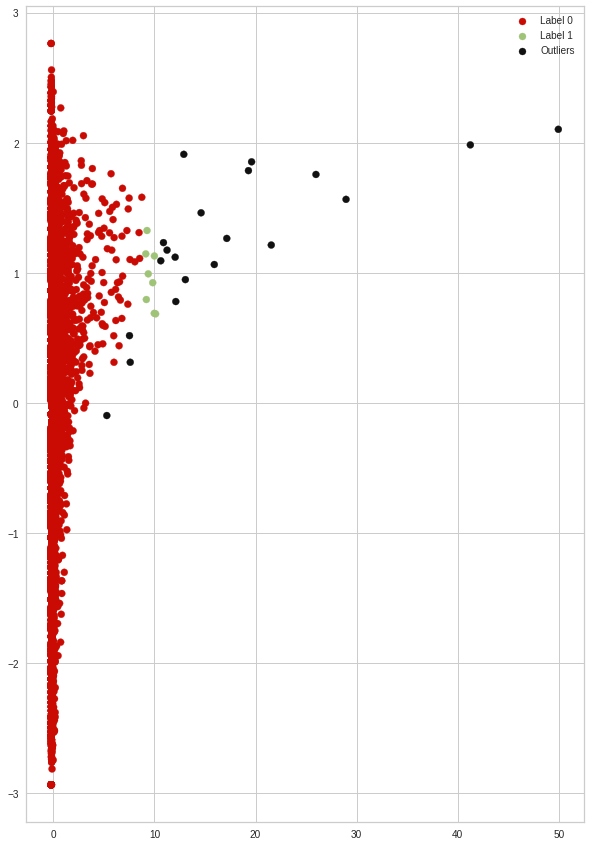

In [ ]:
plt.figure(figsize =(10, 15))
plt.scatter(temp2_scaled['F1'], temp2_scaled['F2'], c = cvec)

# plt.yscale("symlog")

# Building the legend
plt.legend([r, g, k], ['Label 0', 'Label 1', 'Outliers'])
  
plt.show()

# DBSCAN formed 2 clusters and identified outliers as well!

In [ ]:
(instacart_df.groupby('cluster_label_dbscan')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_reorder_rate = ('reorder_rate','mean'),
     ))

,num_products_in_cluster,mean_num_orders,mean_reorder_rate
cluster_label_dbscan,,,
-1,20,6764.100000,0.734811
0,13349,84.798037,0.514551
1,8,3681.250000,0.683664


In [ ]:
#Comparing with Kmeans++ output
(instacart_df.groupby('cluster_id_v2')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_reorder_rate = ('reorder_rate','mean')
     ))

,num_products_in_cluster,mean_num_orders,mean_reorder_rate
cluster_id_v2,,,
0,123,2176.512195,0.687332
1,5300,42.956226,0.338975
2,7946,90.247546,0.629411
3,8,10526.875000,0.811776


Summarizing DBSCAN results <br>
Compared to the KMeans algorithm, DBSCAN algorithm could perform fairly well.
Using the two algorithm approach we were able to identify additional data points such as:


*   Cluster 1 identified by DBSCAN has 68% reorder rate. This cluster also has more than 3600 average number of orders but only consists of 8 products. 
*   We also got another another cluster (clusters 0) which consists of the majority of the products with a relatively low mean number of orders at 84 and a medium reorder-rate of 51%. Based on the product IDs we could use this info to create a favorable superset that overlaps with K-Means cluster identification
* Similarly low performing items could be identified to further refine the product list

